### Importing Modules (p472)

In [1]:
from collections import defaultdict
    
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy # used internally by statsmodels 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Introduction to Statistical Modeling (p473)

### Defining Statistical Models with Patsy (p474)

In [3]:
# observed values : y
y = np.array([1, 2, 3, 4, 5])

# independent variables : x1, x2
x1 = np.array([6, 7, 8, 9, 10])
x2 = np.array([11, 12, 13, 14, 15])

# design matrix : [1, x1, x2, x1x2]
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T
X

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [4]:
# solve for the unknown coefficient vector B
# using least-square-fit given the design matrix X
# and observation vector y
beta, res, rank, sval = np.linalg.lstsq(X, y, rcond=None)
beta

array([-5.55555556e-01,  1.88888889e+00, -8.88888889e-01, -1.11022302e-15])

In [5]:
# Patsy offers a convenient formula for defining a model
# and automatically constructing the relevant design matrices
data = {"y": y, "x1": x1, "x2": x2}
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data)

In [6]:
# the design matrices for the given data
y

DesignMatrix with shape (5, 1)
  y
  1
  2
  3
  4
  5
  Terms:
    'y' (column 0)

In [7]:
# specified model formula
X

DesignMatrix with shape (5, 4)
  Intercept  x1  x2  x1:x2
          1   6  11     66
          1   7  12     84
          1   8  13    104
          1   9  14    126
          1  10  15    150
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x1:x2' (column 3)

In [8]:
# Patsy-supplied subclass of the standard NumPy array contains
# additional metadata and an altered printing representation
type(X)

patsy.design_info.DesignMatrix

In [9]:
# (optional) cast DesignMatrix instance into an ndarray object
np.array(X)

array([[  1.,   6.,  11.,  66.],
       [  1.,   7.,  12.,  84.],
       [  1.,   8.,  13., 104.],
       [  1.,   9.,  14., 126.],
       [  1.,  10.,  15., 150.]])

In [10]:
# set return_type to dataframe so that patsy.dmatrices funciton
# returns design matrices in the form of Pandas Dataframe
df_data = pd.DataFrame(data)
y, X = patsy.dmatrices(
    "y ~ 1 + x1 + x2 + x1:x2",
    df_data,
    return_type="dataframe"
)
X

,Intercept,x1,x2,x1:x2
0,1.0,6.0,11.0,66.0
1,1.0,7.0,12.0,84.0
2,1.0,8.0,13.0,104.0
3,1.0,9.0,14.0,126.0
4,1.0,10.0,15.0,150.0


In [11]:
# invoke the fit method to fit the model to the data 
# encoded in the design matrices
model = sm.OLS(y, X)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -7.771561e-16
dtype: float64

In [12]:
# pass the Patsy formula for the model when creating a model instance
# using the statsmodels formula API
model = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -7.771561e-16
dtype: float64

In [13]:
data = defaultdict(lambda: np.array([]))
patsy.dmatrices("y ~ a", data=data)[1].design_info.term_names

['Intercept', 'a']

In [14]:
# Patsy includes the intercept constant by default
# which can be written explicitly using y ~ 1 + a
patsy.dmatrices("y ~ 1 + a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [15]:
# use the notation -1 to remove the intercept in the model
patsy.dmatrices("y ~ -1 + a + b", data=data)[1].design_info.term_names

['a', 'b']

In [16]:
# a * b are expanded to include all lower-order interaction terms
patsy.dmatrices("y ~ a * b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b']

In [17]:
# higher-order expansions
patsy.dmatrices("y ~ a * b * c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c', 'a:b:c']

In [18]:
# remove certain term from a formula
patsy.dmatrices("y ~ a * b * c - a:b:c", data=data)[1].design_info.term_names

['Intercept', 'a', 'b', 'a:b', 'c', 'a:c', 'b:c']

In [19]:
# + and - are used for set-like operations
data = {k: np.array([]) for k in ["y", "a", "b", "c"]}
patsy.dmatrices("y ~ a + b", data=data)[1].design_info.term_names

['Intercept', 'a', 'b']

In [20]:
# need to wrap the expression in a function call (e.g. I(...))
# to represent the arithmetic operations
patsy.dmatrices("y ~ I(a + b)", data=data)[1].design_info.term_names

['Intercept', 'I(a + b)']

In [21]:
# express a power of a variable
patsy.dmatrices("y ~ I(a**2)", data=data)[1].design_info.term_names

['Intercept', 'I(a ** 2)']

In [22]:
# apply transformations of the input data using 
# arbitrary Python function calls in the formula
patsy.dmatrices("y ~ np.log(a) + b", data=data)[1].design_info.term_names

['Intercept', 'np.log(a)', 'b']

In [23]:
# transform variables
z = lambda x1, x2: x1+x2
patsy.dmatrices("y ~ z(a, b)", data=data)[1].design_info.term_names

['Intercept', 'z(a, b)']

In [24]:
# for a numerical variable, the corresponding column in the design matrix
# corresponds to the data vector
data = {"y": [1, 2, 3], "a": [1, 2, 3]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a
0,1.0
1,2.0
2,3.0


In [25]:
# request that a variable should be treated as a categorical variable
# using C(x) notation
patsy.dmatrices("y ~ - 1 + C(a)", data=data, return_type="dataframe")[1]

,C(a)[1],C(a)[2],C(a)[3]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [26]:
# variables with nonnumerical values are interpreted/treated 
# as categorical values
data = {"y": [1, 2, 3], "a": ["type A", "type B", "type C"]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

,a[type A],a[type B],a[type C]
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [27]:
# encode the categorical variables with orthogonoal polynomials
# using C(a, Poly)
patsy.dmatrices("y ~ - 1 + C(a, Poly)", data=data, return_type="dataframe")[1]

,"C(a, Poly).Constant","C(a, Poly).Linear","C(a, Poly).Quadratic"
0,1.0,-7.071068e-01,0.408248
1,1.0,-5.551115e-17,-0.816497
2,1.0,7.071068e-01,0.408248


### Linear Regression (p485)

In [28]:
# prepare random data
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2})

# store the true value of y in the y_true
def y_true(x1, x2):
    return 1 + 2 * x1 + 3 * x2 + 4 * x1 * x2
data["y_true"] = y_true(x1, x2)

In [29]:
# add a normal distributed noise to the true value
e = 0.5 * np.random.randn(N)
data["y"] = data["y_true"] + e

In [30]:
# fit the model to the data using OLS
model = smf.ols("y ~ x1 + x2", data)
result = model.fit()

In [31]:
# display several types of test statistics, ...
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     20.03
Date:                Fri, 10 Jan 2020   Prob (F-statistic):           5.22e-08
Time:                        20:11:21   Log-Likelihood:                -279.87
No. Observations:                 100   AIC:                             565.7
Df Residuals:                      97   BIC:                             573.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2882      0.405      3.179      0.0

In [32]:
# access R-squared statistic
result.rsquared

0.2923016541403264

In [33]:
# access residuals to investigate whether the assumption of
# normal distributed errors is justified
result.resid.head()

0    2.740634
1   -1.365336
2   -0.357688
3    3.722049
4   -0.501417
dtype: float64

In [34]:
# check for normality
z, p = stats.normaltest(result.fittedvalues.values)
p

0.3729159418332118

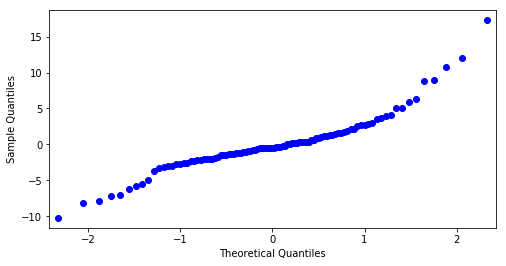

In [35]:
# compare the sample quantiles with the theoretical quantiles
# and the QQ-plot should be close to a straight line if the sampled
# values are normally distributed
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax);

In [36]:
# include the interaction term (x1*x2)
model = smf.ols("y ~ x1 + x2 + x1*x2", data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3422.
Date:                Fri, 10 Jan 2020   Prob (F-statistic):           2.02e-97
Time:                        20:11:21   Log-Likelihood:                -63.086
No. Observations:                 100   AIC:                             134.2
Df Residuals:                      96   BIC:                             144.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9353      0.047     19.991      0.0

In [37]:
# R-squared statistic is higher
result.rsquared

0.9907343562849318

In [38]:
z, p = stats.normaltest(result.fittedvalues.values)
p

2.751187547920928e-11

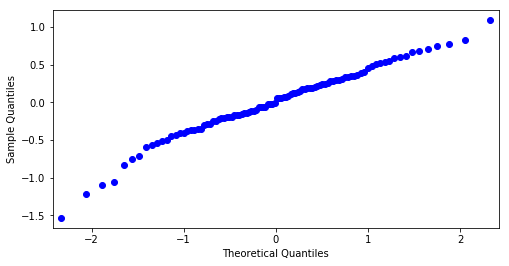

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax);

In [40]:
# extract the model coefficients from the result object
result.params

Intercept    0.935343
x1           1.967753
x2           2.942010
x1:x2        3.920632
dtype: float64

In [41]:
# construct a DataFrame with the x1 and x2 values
x = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x, x)
new_data = pd.DataFrame({"x1": X1.ravel(), "x2": X2.ravel()})

In [42]:
# use the predict method of the result object obtained from
# the fitting of the model to compute the predicted y values
y_pred = result.predict(new_data)

In [43]:
# resize the y_pred vector to a square matrix
y_pred = y_pred.values.reshape(50, 50)

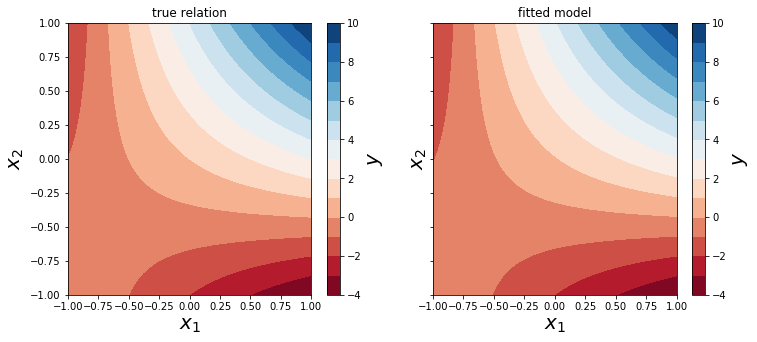

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

plot_y_contour(axes[0], y_true(X1, X2), "true relation")
plot_y_contour(axes[1], y_pred, "fitted model")

#### Example Datasets (p494)

In [45]:
# load a dataset
dataset = sm.datasets.get_rdataset("Icecream", "Ecdat")
dataset.title

'Ice Cream Consumption'

In [46]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
cons      30 non-null float64
income    30 non-null int64
price     30 non-null float64
temp      30 non-null int64
dtypes: float64(2), int64(2)
memory usage: 1.0 KB


In [47]:
# model the consumption as a linear model
# with price and temperature as independent variables
model = smf.ols("cons ~ -1 + price + temp", data=dataset.data)
result = model.fit()

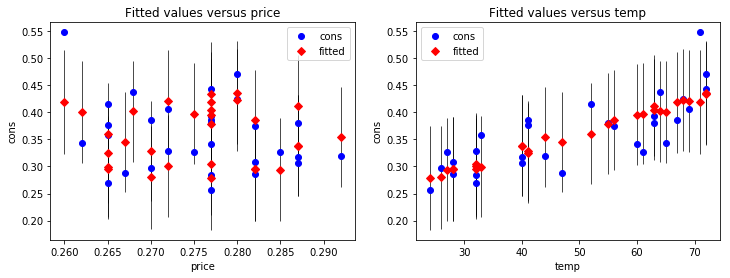

In [48]:
# plot regression graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
smg.plot_fit(result, 0, ax=ax1)
smg.plot_fit(result, 1, ax=ax2);

### Discrete Regression (p496)

#### Logistic Regression (p496)

In [49]:
df = sm.datasets.get_rdataset("iris").data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
Sepal.Length    150 non-null float64
Sepal.Width     150 non-null float64
Petal.Length    150 non-null float64
Petal.Width     150 non-null float64
Species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [50]:
# find the unique types of species
df.Species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [51]:
# create a new dataframe with two species
df_subset = df[df.Species.isin(["versicolor", "virginica"])].copy()

In [52]:
# create a binary variable that corresponds to the two different
# species to use logistic regression
df_subset.Species = df_subset.Species.map({
    "versicolor": 1,
    "virginica": 0
})

In [53]:
# rename the columns
df_subset.rename(
    columns={
        "Sepal.Length": "Sepal_Length",
        "Sepal.Width": "Sepal_Width",
        "Petal.Length": "Petal_Length",
        "Petal.Width": "Petal_Width"
    },
    inplace=True
)

In [54]:
df_subset.head(3)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1


In [55]:
# create a logistic model that attemps to explain the
# value of the Species variable with Petal_length/Width as 
# independent variables
model = smf.logit("Species ~ Petal_Length + Petal_Width", data=df_subset)

In [56]:
# fit the model to the data with max likelihood optimization
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.102818
         Iterations 10


In [57]:
# see the fitted model params with an estimate for z-score
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                  0.8517
Time:                        20:11:26   Log-Likelihood:                -10.282
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 2.303e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.2723     13.612      3.326      0.001      18.594      71.951
Petal_Length    -5.7545      2.306     -2.496      0.013     -10.274      -1.235
Petal_Width    -10.4467      3.756     -2.78

In [58]:
# outputs info about he marginal effects of each explanatory variable
print(result.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                Species
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Petal_Length    -0.1736      0.052     -3.347      0.001      -0.275      -0.072
Petal_Width     -0.3151      0.068     -4.608      0.000      -0.449      -0.181


In [59]:
# prepare a dataframe with the new values of the independent variables
df_new = pd.DataFrame({
    "Petal_Length": np.random.randn(20)*0.5 + 5,
    "Petal_Width": np.random.randn(20)*0.5 + 1.7
})

In [60]:
# predict the value of the response variable for new values
df_new["Species"] = result.predict(df_new)

In [61]:
df_new.head()

,Petal_Length,Petal_Width,Species
0,5.218726,1.328577,7.960475e-01
1,4.675547,1.897342,1.893558e-01
2,5.712993,2.771386,6.459686e-08
3,5.513186,2.139870,1.495030e-04
4,5.217784,1.854729,1.583831e-02


In [63]:
# compare this probability to the threshold value 0.5 to 
# generate predictins for the binary value of the response variable
df_new['Series'] = (df_new["Species"] > 0.5).astype(int)

In [64]:
# obtain model params
params = result.params
alpha0 = -params['Intercept']/params['Petal_Width']
alpha1 = -params['Petal_Length']/params['Petal_Width']

alpha0, alpha1

(4.333650265500957, -0.5508469063829413)

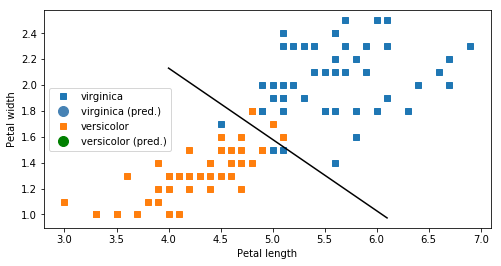

In [65]:
# plot a scatter plot of the fitted (squares) and predicted data (circles)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# species virginica
ax.plot(
    df_subset[df_subset.Species == 0].Petal_Length.values, 
    df_subset[df_subset.Species == 0].Petal_Width.values, 
    's', 
    label='virginica'
)
ax.plot(
    df_new[df_new.Species == 0].Petal_Length.values, 
    df_new[df_new.Species == 0].Petal_Width.values, 
    'o', 
    markersize=10, 
    color="steelblue", 
    label='virginica (pred.)'
)


# species versicolor
ax.plot(
    df_subset[df_subset.Species == 1].Petal_Length.values,
    df_subset[df_subset.Species == 1].Petal_Width.values,
    's', 
    label='versicolor'
)

ax.plot(
    df_new[df_new.Species == 1].Petal_Length.values,
    df_new[df_new.Species == 1].Petal_Width.values,
    'o', 
    markersize=10, 
    color="green", 
    label='versicolor (pred.)'
)


# boundary line
_x = np.array([4.0, 6.1])
ax.plot(_x, alpha0 + alpha1 * _x, 'k')
ax.set_xlabel('Petal length')
ax.set_ylabel('Petal width')
ax.legend();

#### Poisson Model (p502)

In [66]:
dataset = sm.datasets.get_rdataset("discoveries")
# not "values"
df = dataset.data.set_index("time").rename(columns={"value": "discoveries"})
df.head(10).T

time,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869
discoveries,5,3,0,2,0,3,2,3,6,1


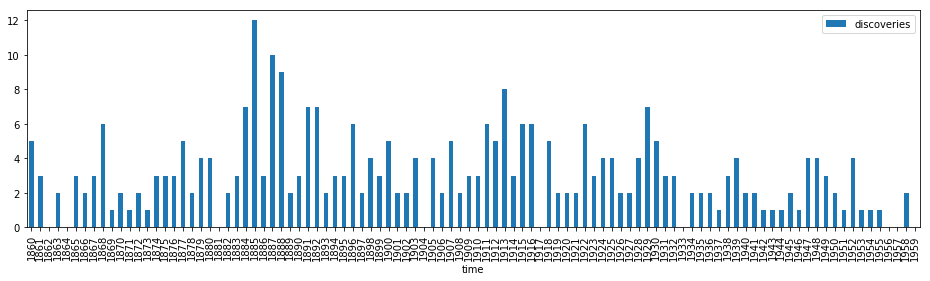

In [67]:
# plot a graph of the number of discoveries per year
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
df.plot(kind='bar', ax=ax);

In [68]:
# fit the data to Poisson process
model = smf.poisson("discoveries ~ 1", data=df)

In [69]:
# perform the fit of the model to the data
result = model.fit()

Optimization terminated successfully.
         Current function value: 2.168457
         Iterations 1


In [70]:
print(result.summary())

                          Poisson Regression Results                          
Dep. Variable:            discoveries   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                   0.000
Time:                        20:11:44   Log-Likelihood:                -216.85
converged:                       True   LL-Null:                       -216.85
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1314      0.057     19.920      0.000       1.020       1.243


In [71]:
# model params are related to the lambda parameter of the 
# Poisson distribution via the exponential function
lmbda = np.exp(result.params)
lmbda

Intercept    3.1
dtype: float64

In [72]:
# compare the histogram of the observed count values with 
# the theoretical counts 
X = stats.poisson(lmbda)

In [73]:
# obtain estimated confidence intervals of the params
result.conf_int()

,0,1
Intercept,1.020084,1.242721


In [74]:
# create random variables for the lower/upper bounds 
# of the confidence interval for the model param
X_ci_l = stats.poisson(np.exp(result.conf_int().values)[0, 0])
X_ci_u = stats.poisson(np.exp(result.conf_int().values)[0, 1])

/Users/geeyeol/.pyenv/versions/3.7.1/envs/python3-staging/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


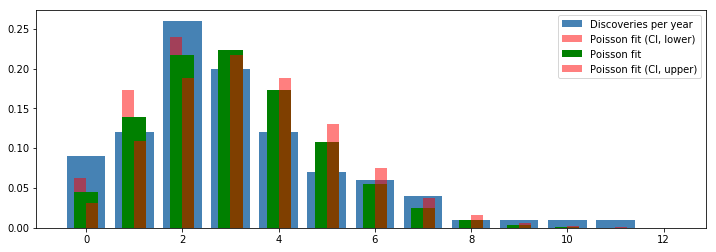

In [75]:
# plot the histogram of the observed counts with the theoretical prob
# mass functions for the Poisson distributions corresponding to the
# fitted model param and its confidence intervals
v, k = np.histogram(df.values, bins=12, range=(0, 12), normed=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(k[:-1], v, color="steelblue",  align='center',label='Discoveries per year')
ax.bar(k-0.125, X_ci_l.pmf(k), color="red", alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, lower)')
ax.bar(k, X.pmf(k), color="green",  align='center', width=0.5, label='Poisson fit')
ax.bar(k+0.125, X_ci_u.pmf(k), color="red",  alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, upper)')
ax.legend();

### Time Series (p506)

In [76]:
# load the dataset
df = pd.read_csv("temperature_outdoor_2014.tsv", header=None, delimiter="\t", names=["time", "temp"])
df.time = pd.to_datetime(df.time, unit="s")
df = df.set_index("time").resample("H").mean()

In [77]:
# extract the observations for March/April and store them in new df
df_march = df[df.index.month == 3]
df_april = df[df.index.month == 4]

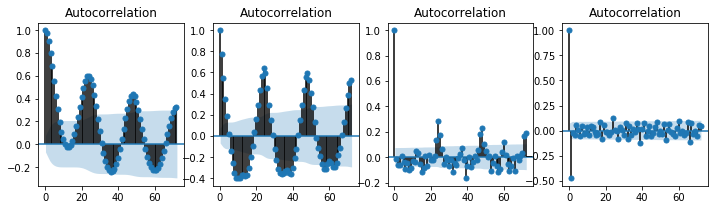

In [78]:
# visualize autocorrelation in a timeseries
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
smg.tsa.plot_acf(df_march.temp, lags=72, ax=axes[0])
smg.tsa.plot_acf(df_march.temp.diff().dropna(), lags=72, ax=axes[1])
smg.tsa.plot_acf(df_march.temp.diff().diff().dropna(), lags=72, ax=axes[2])
smg.tsa.plot_acf(df_march.temp.diff().diff().diff().dropna(), lags=72, ax=axes[3]);

In [79]:
# create an AR model
model = sm.tsa.AR(df_march.temp)

In [80]:
# make the order of the AR model correspond to 72 (hours)
result = model.fit(72)

In [81]:
# test for stationary (residuals) in a time series
sm.stats.durbin_watson(result.resid)

1.9985623006352928

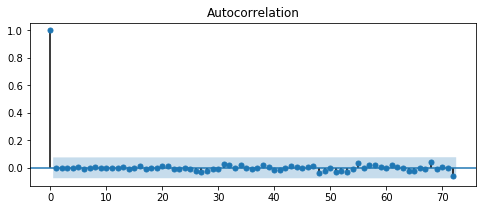

In [82]:
# graph the autocorrelation function for the residuals
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
smg.tsa.plot_acf(result.resid, lags=72, ax=ax);

In [83]:
# forecast the temperature for future dates
temp_3d_forecast = result.predict("2014-04-01", "2014-04-04")

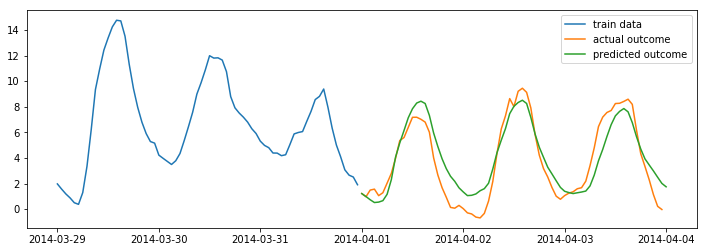

In [84]:
# graph the forecast, previous 3 days of temperature observations
# and the actual outcome
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_march.index.values[-72:], df_march.temp.values[-72:], label="train data")
ax.plot(df_april.index.values[:72], df_april.temp.values[:72], label="actual outcome")
ax.plot(pd.date_range("2014-04-01", "2014-04-4", freq="H").values, temp_3d_forecast, label="predicted outcome")
ax.legend();